# Oil prediction analysis

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xgboost as xgb
import seaborn as sns
import operator as op
import typing as t
import statistics
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn import decomposition
from sklearn.decomposition import PCA

from sklearn.datasets import make_classification

from sklearn.neural_network import MLPRegressor

from sklearn.svm import SVR

from sklearn.preprocessing import MinMaxScaler

from __future__ import annotations

from collections import abc

from functools import partial

from tqdm.auto import trange
from tqdm import trange

from xgboost import XGBClassifier
from xgboost import XGBRegressor

from eBoruta import eBoruta, TrialData, Features, Dataset, setup_logger  
# pip install git+https://github.com/edikedik/eBoruta.git

# Load and analysis of the data

We selected some parameters that could influence the price of oil such as:  
'Year', 'Price Cononut oil', 'Price Sugar', 'Us crude oil reserves', 'Quantity oil embarked', 'Quantity goods embarked', 'Pandemic (covid)', 'War','Electric car registrations', 'World imports', 'World exports', 'Value of Solar Consumption', 'Inflation', 'Value of Wind Consumption', 'Value of Nuclear Consumption', 'Value of Natural Gas Consumption', 'Population', 'OPEC cuts on production', 'Price gold', 'GDP Growth','Crude oil and NGL production', 'World-oil demand', 'Value of Freight Transport'.

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


,Year,Oil brent price ($/bbl),Cononut oil ($/mt),Sugar ($/kg),Us crude oil reserves,Quantity oil embarked (million of tons),Quantity goods embarked (million of tons),Pandemic (covid),War,Electric car registrations,...,Value of Wind Consumption (EJ),Value of Nuclear Consumption (EJ),Value of Natural Gas Consumption (BcF),Population,OPEC cuts on production,Price gold,GDP Growth,Crude oil and NGL production,World-oil demand,Value of Freight Transport
count,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,6.240000e+02,...,624.000000,624.000000,624.000000,6.240000e+02,624.000000,624.000000,624.000000,624.000000,624.000000,6.240000e+02
mean,1995.958333,37.451538,743.386122,0.269103,28183.788462,1539.002240,5854.919505,0.038462,0.057692,8.424563e+05,...,2.414431,18.362341,220.820166,5.774825e+06,0.024038,599.331763,3.152875,3516.240577,3436.283654,1.337433e+08
std,15.023130,30.523005,383.579919,0.144167,5836.814615,244.727308,2715.516484,0.192462,0.233348,2.685918e+06,...,4.370277,9.076341,85.328111,1.260299e+06,0.153291,491.963383,1.631201,615.261810,583.575264,1.109539e+08
min,1970.000000,1.210000,200.000000,0.060000,19121.000000,1049.000000,2605.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.727978,93.025514,3.695380e+06,0.000000,34.990000,-3.115404,2490.520000,2379.400000,1.017289e+07
25%,1982.979167,16.052500,456.750000,0.170000,22454.250000,1356.250000,3495.750000,0.000000,0.000000,0.000000e+00,...,0.000311,9.042216,141.697022,4.670898e+06,0.000000,293.637500,2.519675,2966.917500,2959.425000,4.127752e+07
50%,1995.958333,27.510000,643.000000,0.240000,27495.500000,1594.500000,4704.500000,0.000000,0.000000,0.000000e+00,...,0.092967,23.426071,208.670411,5.784171e+06,0.000000,387.250000,3.307856,3385.230000,3314.160000,8.353648e+07
75%,2008.937500,54.635000,916.282500,0.320000,32854.250000,1741.000747,8084.055192,0.000000,0.000000,3.475000e+03,...,2.375486,25.325763,285.765447,6.833263e+06,0.000000,920.437500,4.146743,4061.740000,3991.250000,2.438308e+08
max,2021.916667,133.870000,2256.000000,1.240000,39001.000000,1881.049999,11070.533090,1.000000,1.000000,1.540493e+07,...,17.503339,27.470872,390.634419,7.909283e+06,1.000000,1964.900000,6.407434,4619.320000,4455.850000,3.381681e+08


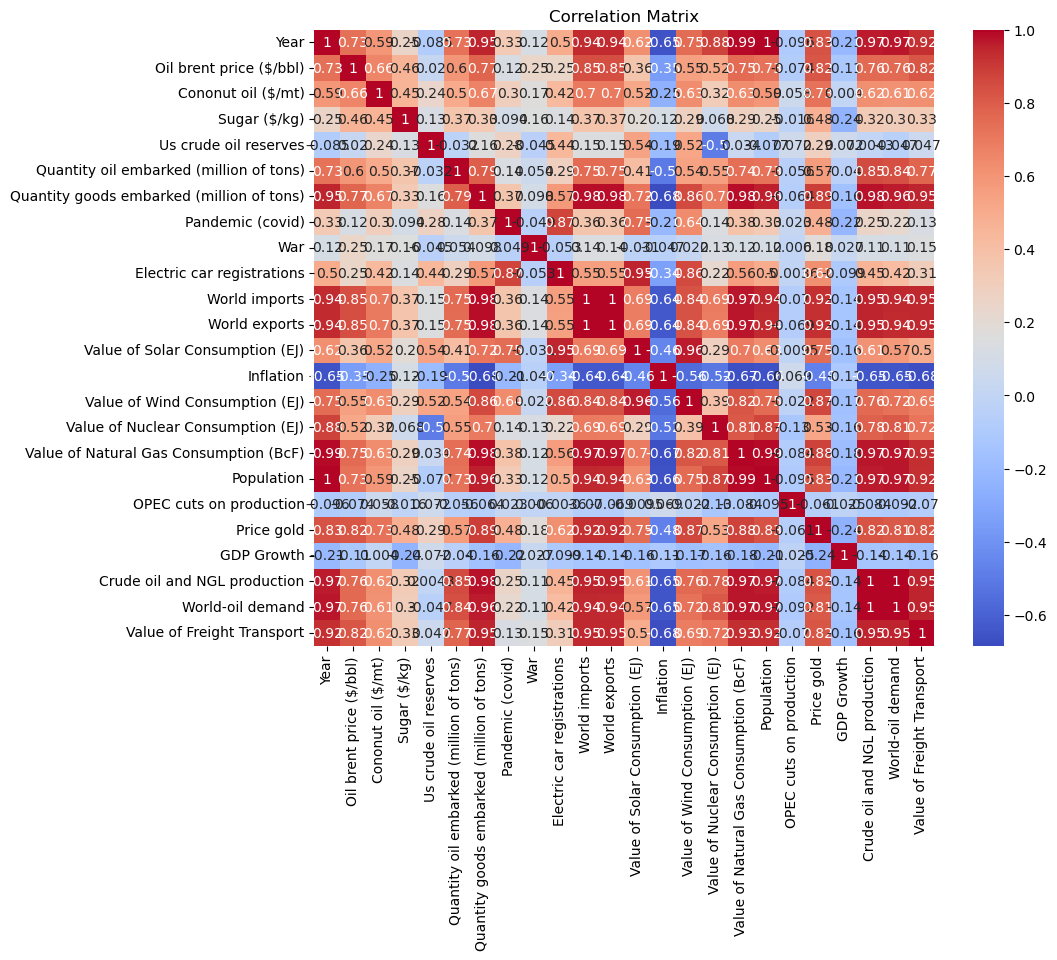

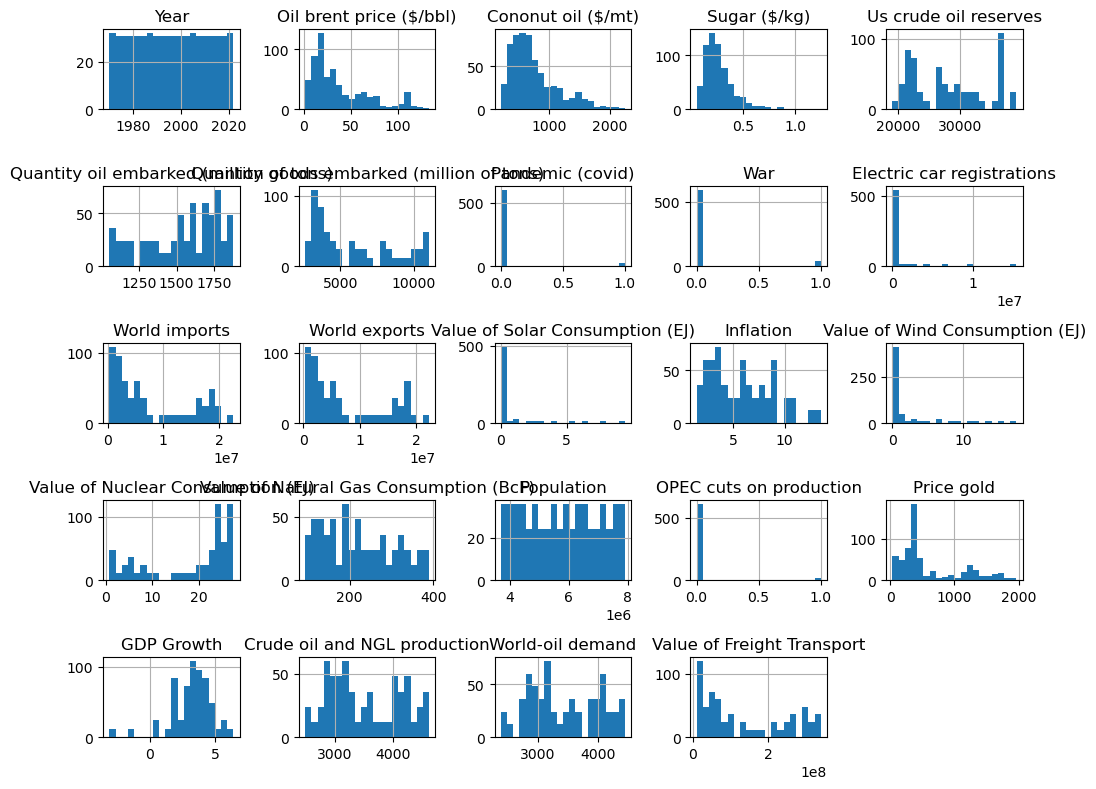

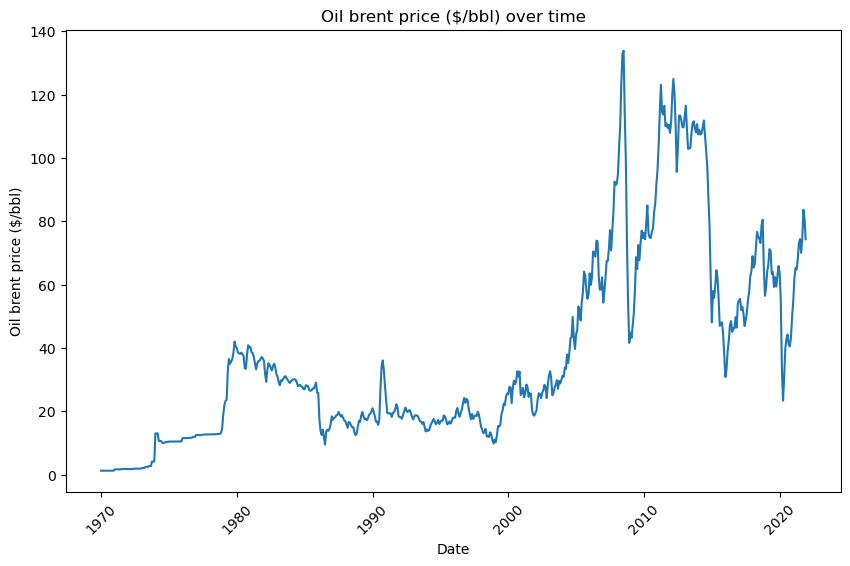

In [8]:
# Load the csv
df = pd.read_csv('data_final1.csv')

x = df.drop(['Oil brent price ($/bbl)'], 1)
y = df['Oil brent price ($/bbl)']

# Normalize x
min_vals = x.min()
max_vals = x.max()
x = (x - min_vals) / (max_vals - min_vals)

display(df.describe())

corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

df.hist(figsize=(10, 8), bins=20)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Oil brent price ($/bbl)'])
plt.xlabel('Date')
plt.ylabel('Oil brent price ($/bbl)')
plt.title('Oil brent price ($/bbl) over time')
plt.xticks(rotation=45)
plt.show()


# Explore different models 

In [9]:
def cross_validate(model, x, y, n, score_fn, agg_fn, stratified):
    if stratified:
        kf = StratifiedKFold(n_splits=n)
    else:
        kf = KFold(n_splits=n)

    scores = []
    for train_idx, test_idx in kf.split(x, y):
        X_train, Y_train = x.iloc[train_idx], y.iloc[train_idx]
        X_test, Y_test = x.iloc[test_idx], y.iloc[test_idx]
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        score = score_fn(Y_test, y_pred)
        scores.append(score)
    return agg_fn(scores)

    

In [10]:
print(x.columns)
df = pd.read_csv('data_final1.csv')
x = df.loc[:, df.columns != 'Oil brent price ($/bbl)']
y = df['Oil brent price ($/bbl)']
selected_columns = ['Year', 'World imports', 'Price gold', 'War', 'Inflation']
# selected_columns2 = ['Year', 'World imports', 'Cononut oil ($/mt)', 'Sugar ($/kg)', 'Inflation']
xs = x.loc[:, selected_columns]

# define models to cross-validate
models = []
models.append(('XGBRegressor',XGBRegressor(),mean_squared_error,np.mean, False))
#models.append(('DecisionTree', DecisionTreeRegressor(),mean_squared_error,np.mean, False)) 
models.append(('RandomForest', RandomForestRegressor(),mean_squared_error,np.mean, False))
#models.append(('LogisticRegression', LogisticRegression(),mean_squared_error,np.mean, False))
stratified=0

# evaluate each model using cross-validation
results = []
n=4
for name, model, score_fn, agg_fn, stratified in models:
    print (name, model, score_fn, agg_fn, stratified )
    score=cross_validate(model, x, y, n, score_fn, agg_fn, stratified)
    score1=cross_validate(model, xs, y, n, score_fn, agg_fn, stratified)
    # results.append(score)
    print(f'x: {score}')
    print(f'xs: {score1}')

# best_model = models[np.argmin(results)]
# print(f'Best_model={best_model}')


Index(['Year', 'Cononut oil ($/mt)', 'Sugar ($/kg)', 'Us crude oil reserves',
       'Quantity oil embarked (million of tons)',
       'Quantity goods embarked (million of tons)', 'Pandemic (covid)', 'War',
       'Electric car registrations', 'World imports', 'World exports',
       'Value of Solar Consumption (EJ)', 'Inflation',
       'Value of Wind Consumption (EJ)', 'Value of Nuclear Consumption (EJ)',
       'Value of Natural Gas Consumption (BcF)', 'Population',
       'OPEC cuts on production', 'Price gold', 'GDP Growth',
       'Crude oil and NGL production', 'World-oil demand',
       'Value of Freight Transport'],
      dtype='object')
XGBRegressor XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type

## PCA transformation on data

In [11]:
#Import and normalize the data

df = pd.read_csv('data_final1.csv')
x = df.loc[:, df.columns != 'Oil brent price ($/bbl)']
y = df['Oil brent price ($/bbl)']

x = (x - x.min()) / (x.max() - x.min())

In [12]:
pca = PCA()
x_pca = pca.fit_transform(x)

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print(explained_variance_ratio)
print(len(explained_variance_ratio))

# Determine the number of components that explain 90% of the variance
n_components = np.argmax(explained_variance_ratio >= 0.9) + 1

pca = PCA(n_components=n_components)

x_pca = pca.fit_transform(x)

x_pca = pd.DataFrame(x_pca)

selected_features = pca.components_
print(len(selected_features))

[0.69328997 0.81075577 0.85584821 0.89320271 0.92416949 0.94515526
 0.9612409  0.97611674 0.98399289 0.98973713 0.99416307 0.99611857
 0.99790106 0.99906606 0.99948717 0.99967018 0.9997882  0.99987206
 0.99993131 0.99996678 0.99999043 0.99999957 1.        ]
23
5


We need 5 features to get 90% of the variance explained, just as many features as our selection.

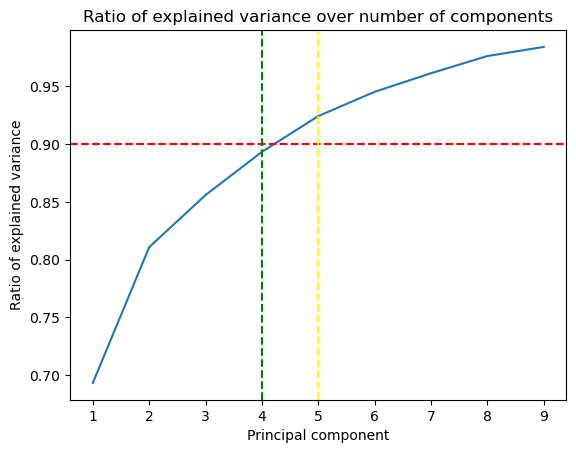

In [13]:
plt.plot(range(1, 10), explained_variance_ratio[:9])
plt.xlabel('Principal component')
plt.ylabel('Ratio of explained variance')
plt.axhline(y=0.9, color='red', linestyle='--')
plt.axvline(x=5, color='yellow', linestyle='--')
plt.axvline(x=4, color='green', linestyle='--')
plt.title('Ratio of explained variance over number of components')
plt.show()

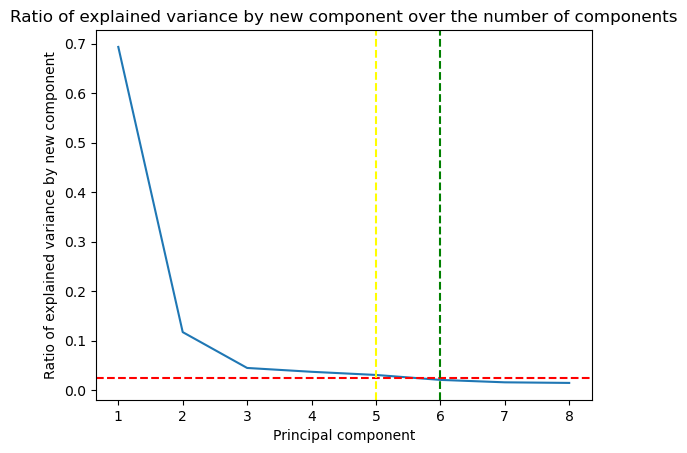

In [14]:
pca = decomposition.PCA(n_components=8)
pca.fit(x)
X_transformed = pca.transform(x)

plt.plot(range(1, 9), pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Ratio of explained variance by new component')
plt.axhline(y=0.025, color='red', linestyle='--')
plt.axvline(x=5, color='yellow', linestyle='--')
plt.axvline(x=6, color='green', linestyle='--')
plt.title('Ratio of explained variance by new component over the number of components')
plt.show()

After 5 components, less than 2.5% of the variance is explained by adding a new parameter, another reason to keep 5 components.

In [15]:
# define models to cross-validate
models = []
models.append(('XGBRegressor',XGBRegressor(),mean_squared_error,np.mean, False))
models.append(('DecisionTree', DecisionTreeRegressor(),mean_squared_error,np.mean, False)) 
models.append(('RandomForest', RandomForestRegressor(),mean_squared_error,np.mean, False))

models_PCA = []
models_PCA.append(('XGBRegressor',XGBRegressor(),mean_squared_error,np.mean, False))
models_PCA.append(('DecisionTree', DecisionTreeRegressor(),mean_squared_error,np.mean, False)) 
models_PCA.append(('RandomForest', RandomForestRegressor(),mean_squared_error,np.mean, False))
#models.append(('LogisticRegression', LogisticRegression(),mean_squared_error,np.mean, False))
stratified=0

# evaluate each model using cross-validation
results = []
n=4
for name, model, score_fn, agg_fn, stratified in models:
    print('raw data')
    print (name, model, score_fn, agg_fn, stratified )
    score=cross_validate(model, x, y, n, score_fn, agg_fn, stratified)
    results.append(score)
    print(score)
    
results_PCA = []
n=4
for name, model, score_fn, agg_fn, stratified in models_PCA:
    print('data transformed by PCA')
    print (name, model, score_fn, agg_fn, stratified )
    score=cross_validate(model, x_pca, y, n, score_fn, agg_fn, stratified)
    results_PCA.append(score)
    print(score)

best_model = models[np.argmin(results)]
print(f'Best_model={best_model}')
best_model_PCA = models_PCA[np.argmin(results_PCA)]
print(f'Best_model={best_model_PCA}')

raw data
XGBRegressor XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) <function mean_squared_error at 0x7efe23fbab00> <function mean at 0x7efef426d360> False
621.124659375191
raw data
DecisionTree DecisionTreeRegressor() <function mean_squared_error at 0x7efe23fbab00> <function mean at 0x7efef426d360> Fals

First, notice that the model with the lowest mean squared error is XGB regressor in both cases.

We also see that using PCA with 5 components on our data is very efficient as it reduces our error from 621 to 253, more than divides it by 2.

# Feature selection

## Wrapper method  
##   -  Sequential Feature Selector "forward"

['Pandemic (covid)', 'War', 'Electric car registrations', 'World imports', 'OPEC cuts on production']


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


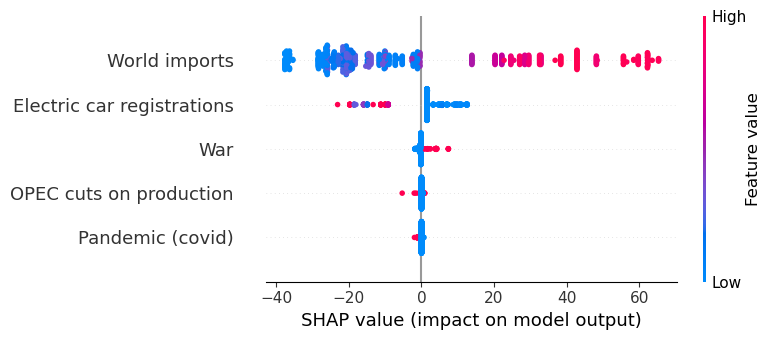

Estimator: RandomForestRegressor()
selected_features: ['World imports', 'Electric car registrations', 'War', 'OPEC cuts on production', 'Pandemic (covid)']

['Pandemic (covid)', 'War', 'Electric car registrations', 'World imports', 'OPEC cuts on production']


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


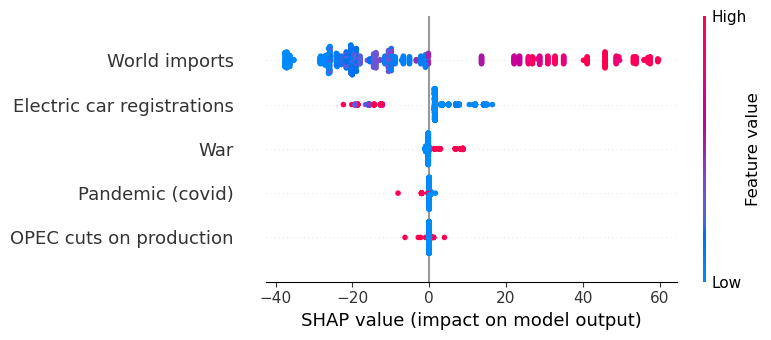

Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
selected_features: ['World imports', 'Electric car registrations', 'War', 'Pandemic (covid)', 'OPEC cuts on production']



In [16]:
estimators = [RandomForestRegressor, XGBRegressor]

for estimator in estimators: 
    selector = SequentialFeatureSelector(estimator=estimator(),
                                         n_features_to_select=5,
                                         direction='forward')

    selector.fit(x, y)


    selected_features = x.columns[selector.support_].tolist()
    

    print(selected_features)
    
    estimator = estimator()
    estimator.fit(x[selected_features], y)
    
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer.shap_values(x[selected_features])
    
    shap.summary_plot(shap_values, x[selected_features], feature_names=selected_features)
    
    selected_feature_importances = pd.DataFrame({'Feature': selected_features, 'Importance': np.abs(shap_values).mean(axis=0)})
    selected_feature_importances = selected_feature_importances.sort_values(by='Importance', ascending=False)
    top_5_features = selected_feature_importances['Feature'].head(5).tolist()
        
        
    print(f"Estimator: {estimator}")
    print(f"selected_features: {top_5_features}")
    
    print()





    

## -  Recursive Feature Elimination 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


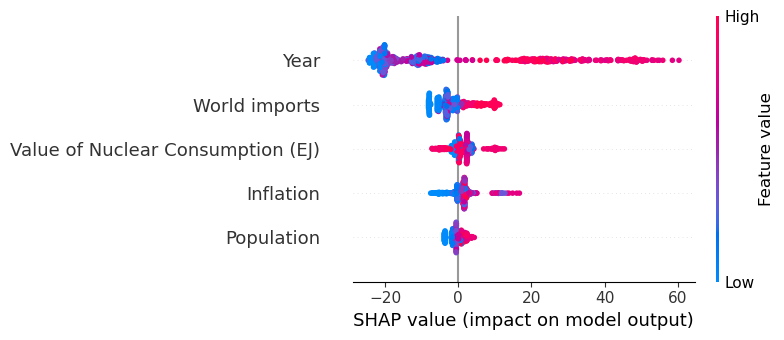

Estimator: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
selected_features: ['Year', 'World imports', 'Value of Nuclear Consumption (EJ)', 'Inflation', 'Population']



ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


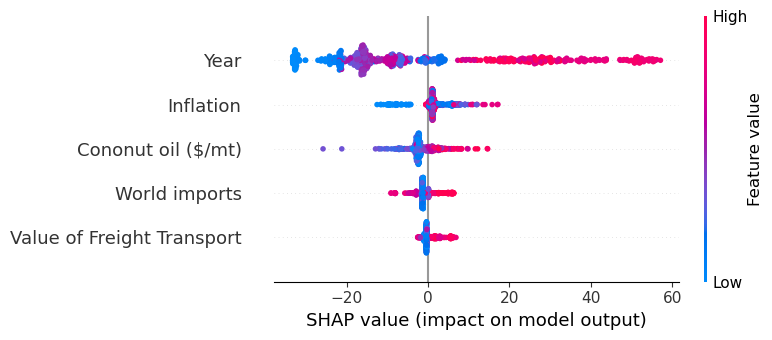

Estimator: <class 'xgboost.sklearn.XGBRegressor'>
selected_features: ['Year', 'Inflation', 'Cononut oil ($/mt)', 'World imports', 'Value of Freight Transport']



In [17]:
estimators = [RandomForestRegressor, XGBRegressor]

for estimator in estimators: 
    model = estimator()
    rfe = RFE(estimator=model, n_features_to_select=5)
    rfe.fit(x, y)
    feature_indices = rfe.get_support(indices=True)
    selected_features = x.columns[feature_indices]

    selected_x = x[selected_features]
    model.fit(selected_x, y)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(selected_x)
    shap.summary_plot(shap_values, selected_x, feature_names=selected_features)

    selected_feature_importances = pd.DataFrame({'Feature': selected_features, 'Importance': np.abs(shap_values).mean(axis=0)})
    selected_feature_importances = selected_feature_importances.sort_values(by='Importance', ascending=False)
    top_5_features = selected_feature_importances['Feature'].head(5).tolist()
        
        
    print(f"Estimator: {estimator}")
    print(f"selected_features: {top_5_features}")
    
    print()



## - Boruta

Boruta trials:   0%|          | 0/20 [00:00<?, ?it/s]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

features accepted: ['Year' 'Cononut oil ($/mt)' 'Sugar ($/kg)'
 'Quantity oil embarked (million of tons)' 'World imports' 'Inflation'
 'Price gold' 'Value of Freight Transport']
features rejected: ['Quantity goods embarked (million of tons)' 'Pandemic (covid)' 'War'
 'Electric car registrations' 'World exports'
 'Value of Solar Consumption (EJ)' 'Value of Wind Consumption (EJ)'
 'Value of Nuclear Consumption (EJ)'
 'Value of Natural Gas Consumption (BcF)' 'Population'
 'OPEC cuts on production' 'GDP Growth' 'World-oil demand']
features tentative: ['Us crude oil reserves' 'Crude oil and NGL production']


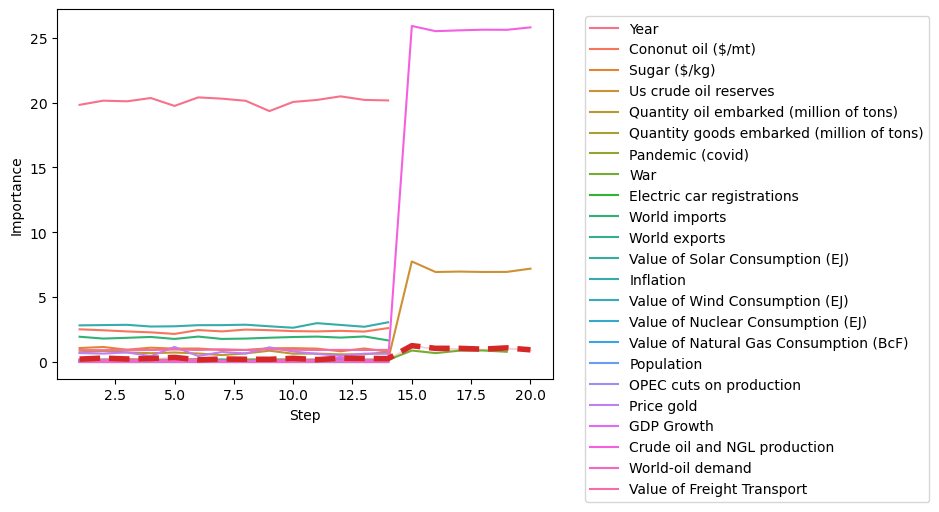

                                      Feature  Importance
0                                        Year   20.353813
12                                  Inflation    2.827759
1                          Cononut oil ($/mt)    2.487869
9                               World imports    1.869873
2                                Sugar ($/kg)    1.062382
22                 Value of Freight Transport    0.936522
18                                 Price gold    0.676606
4     Quantity oil embarked (million of tons)    0.586781
3                       Us crude oil reserves    0.226320
7                                         War    0.154251
20               Crude oil and NGL production    0.112105
19                                 GDP Growth    0.109582
14          Value of Nuclear Consumption (EJ)    0.089184
5   Quantity goods embarked (million of tons)    0.062859
17                    OPEC cuts on production    0.010965
21                           World-oil demand    0.006995
11            

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [18]:
def plot_imp_history(df_history: pd.DataFrame):
    sns.lineplot(x='Step', y='Importance', hue='Feature', data=df_history)
    sns.lineplot(x='Step', y='Threshold', data=df_history, linestyle='--', linewidth=4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
boruta = eBoruta(n_iter = 20, verbose=2, classification = False, test_stratify = False, pvalue = 0.001, percentile = 100) 
boruta.fit(x, y, model = XGBRegressor());
features = boruta.features_
print(f'features accepted: {features.accepted}')
print(f'features rejected: {features.rejected}')
print(f'features tentative: {features.tentative}')

df = features.history
plot_imp_history(df)
r=boruta.rank(sort = True)
print(r)
dictionary = dict(zip(r['Feature'], r['Importance'].apply(lambda x: [x])))
print(dictionary)


## Embelled method
## - XGboost

Index(['Value of Freight Transport', 'Inflation', 'Year', 'World imports',
       'Quantity oil embarked (million of tons)'],
      dtype='object')


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


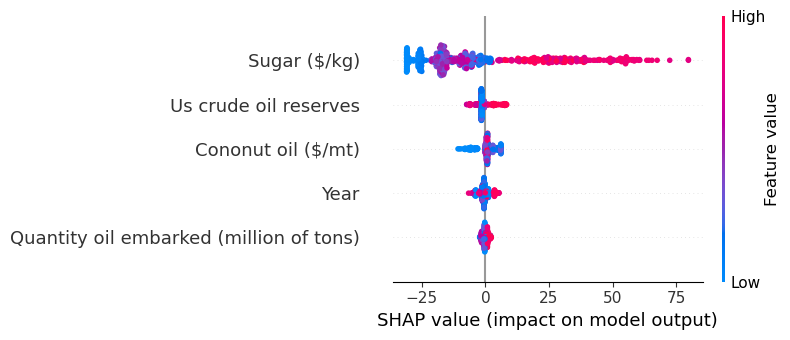

In [19]:

boost = XGBRegressor()
boost.fit(x, y)
p_boost = boost.predict(x)

feature_importance = boost.feature_importances_

top_5_indices = feature_importance.argsort()[-5:][::-1]
top_5_features = x.columns[top_5_indices]
print(top_5_features)

x_top_5 = x[top_5_features]

boost.fit(x_top_5, y)

explainer = shap.TreeExplainer(boost)

shap_values = explainer.shap_values(x_top_5)

shap.summary_plot(shap_values, x_top_5, feature_names=x.columns)






## Filter method
## - Correlation 

World exports                                0.848062
World imports                                0.846612
Value of Freight Transport                   0.821300
Price gold                                   0.818137
Quantity goods embarked (million of tons)    0.770280
Name: Oil brent price ($/bbl), dtype: float64


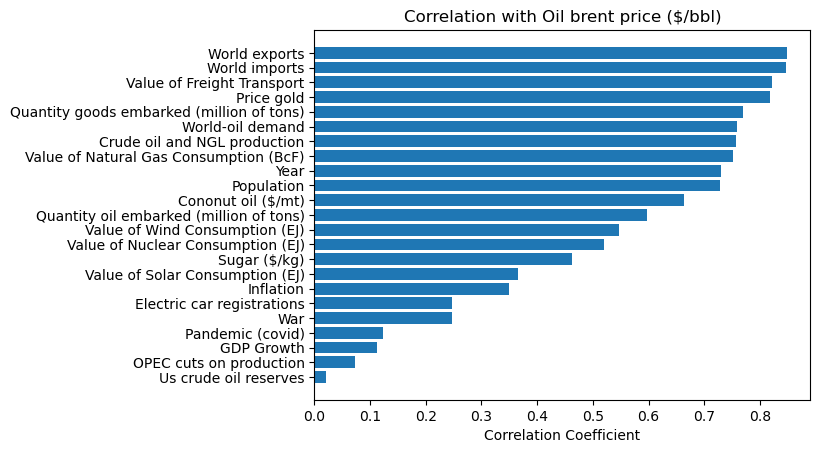

In [20]:
df = pd.read_csv('data_final1.csv')
correlation_matrix = df.corr()

threshold = 0.70

target_correlation = correlation_matrix['Oil brent price ($/bbl)']

target_correlation_sorted = target_correlation.sort_values(ascending=False)

selected_features = 0


print(target_correlation_sorted[1:6])

corr_with_target = df.corr()['Oil brent price ($/bbl)'].abs().sort_values(ascending=True)
d = corr_with_target.to_dict()
del d['Oil brent price ($/bbl)']
data = pd.Series(d)
plt.barh(data.index, data.values)
plt.xlabel('Correlation Coefficient')
plt.title(f'Correlation with Oil brent price ($/bbl)')
plt.show()




## - ANOVA F-v

In [21]:

f_scores, p_values = f_classif(x, y)

feature_scores = pd.DataFrame({'Feature': x.columns, 'F-Score': f_scores, 'p-value': p_values})

feature_scores = feature_scores.sort_values('F-Score', ascending=False)

print(feature_scores[:5])


                                      Feature    F-Score       p-value
18                                 Price gold  43.436120  3.043885e-78
10                              World exports  32.849669  1.474428e-70
9                               World imports  32.462153  3.114629e-70
5   Quantity goods embarked (million of tons)  22.952531  8.055454e-61
22                 Value of Freight Transport  20.611037  6.217251e-58


## Selection

According to the previous studies, the most important parameters, sort in descending order of importance, are:  
- Year
- World imports
- World exports
- Inflation
- Price gold
- War
- OPEC cuts on production

## Correlation

We want to avoid having 2 highly correlated features in our small selection. 

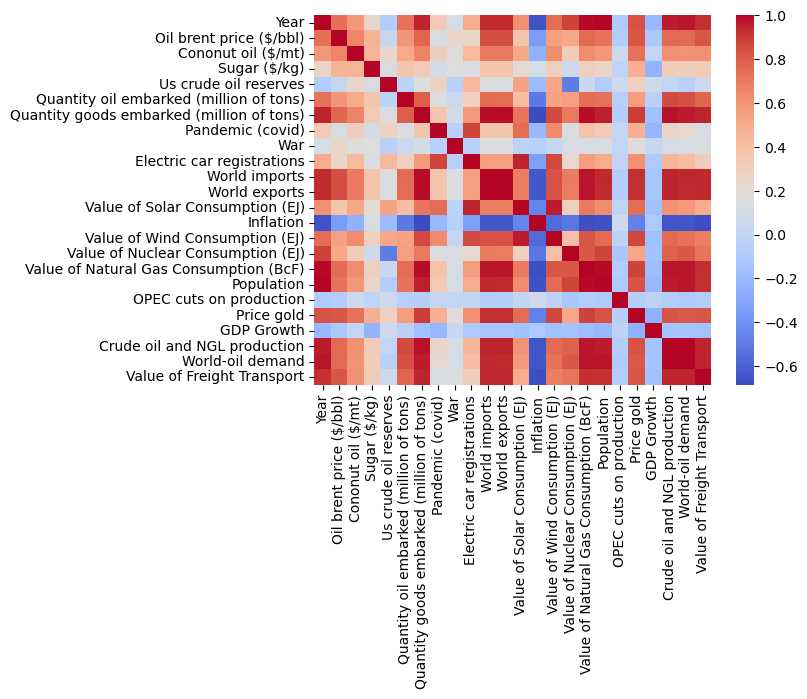

In [22]:

corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)

plt.show()


In [23]:
df2=df.copy()
df2.drop(['Oil brent price ($/bbl)'], 1)
corr_threshold = 0.95

corr_matrix = df.corr().abs()

highly_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] >= corr_threshold:
            feature_i = corr_matrix.columns[i]
            feature_j = corr_matrix.columns[j]
            highly_corr_features.add((feature_i, feature_j))

print("highly_corr_features: ", highly_corr_features)



highly_corr_features:  {('Value of Natural Gas Consumption (BcF)', 'Quantity goods embarked (million of tons)'), ('Population', 'Year'), ('Quantity goods embarked (million of tons)', 'Year'), ('World exports', 'Quantity goods embarked (million of tons)'), ('World-oil demand', 'Year'), ('Population', 'Quantity goods embarked (million of tons)'), ('World imports', 'Quantity goods embarked (million of tons)'), ('Population', 'Value of Natural Gas Consumption (BcF)'), ('Value of Freight Transport', 'World-oil demand'), ('World-oil demand', 'Quantity goods embarked (million of tons)'), ('Crude oil and NGL production', 'Year'), ('Value of Solar Consumption (EJ)', 'Electric car registrations'), ('World-oil demand', 'Value of Natural Gas Consumption (BcF)'), ('Value of Wind Consumption (EJ)', 'Value of Solar Consumption (EJ)'), ('Value of Freight Transport', 'Crude oil and NGL production'), ('Crude oil and NGL production', 'Quantity goods embarked (million of tons)'), ('Value of Natural Gas Co

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


Since "World exports" and "World imports" are highly correlated, we keep only one of the two (the more important one).  
Here is the final selection (the most important parameters):  
- Year
- World imports
- Inflation
- Price gold
- War

## Retraining with the selected features

Now we want to compare the PCA components with our selected features

In [24]:
x_selected = x[['Year', 'World imports', 'Price gold', 'War', 'Inflation']]

x_selected

,Year,World imports,Price gold,War,Inflation
0,0.000000,0.0,0.000000,0.0,0.378402
1,0.001605,0.0,0.000000,0.0,0.378402
2,0.003210,0.0,0.000109,0.0,0.378402
3,0.004815,0.0,0.000161,0.0,0.378402
4,0.006421,0.0,0.000446,0.0,0.378402
...,...,...,...,...,...
619,0.993579,1.0,0.927898,0.0,0.164874
620,0.995185,1.0,0.922250,0.0,0.164874
621,0.996790,1.0,0.884917,0.0,0.164874
622,0.998395,1.0,0.898570,0.0,0.164874


In [25]:
# define models to cross-validate
models_PCA = []
models_PCA.append(('XGBRegressor',XGBRegressor(),mean_squared_error,np.mean, False))
models_PCA.append(('DecisionTree', DecisionTreeRegressor(),mean_squared_error,np.mean, False)) 
models_PCA.append(('RandomForest', RandomForestRegressor(),mean_squared_error,np.mean, False))

models_selected = []
models_selected.append(('XGBRegressor',XGBRegressor(),mean_squared_error,np.mean, False))
models_selected.append(('DecisionTree', DecisionTreeRegressor(),mean_squared_error,np.mean, False)) 
models_selected.append(('RandomForest', RandomForestRegressor(),mean_squared_error,np.mean, False))

# evaluate each model using cross-validation
    
results_PCA = []
n=4
for name, model, score_fn, agg_fn, stratified in models_PCA:
    print('Data transformed by PCA')
    print (name, model, score_fn, agg_fn, stratified )
    score=cross_validate(model, x_pca, y, n, score_fn, agg_fn, stratified)
    results_PCA.append(score)
    print(score)
    
results_selected = []
n=4
for name, model, score_fn, agg_fn, stratified in models_selected:
    print('Data with selected features')
    print (name, model, score_fn, agg_fn, stratified )
    score=cross_validate(model, x_selected, y, n, score_fn, agg_fn, stratified)
    results_selected.append(score)
    print(score)
    

best_model_PCA = models_PCA[np.argmin(results_PCA)]
print(f'Best_model={best_model_PCA}')
best_model_selected = models[np.argmin(results_selected)]
print(f'Best_model={best_model_selected}')

Data transformed by PCA
XGBRegressor XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) <function mean_squared_error at 0x7efe23fbab00> <function mean at 0x7efef426d360> False
253.14421665316576
Data transformed by PCA
DecisionTree DecisionTreeRegressor() <function mean_squared_error at 0x7efe23fbab00> <funct

Once again, XGB regressor is the best model.

We notice that PCA has a better score than our selection: an error of 253 instead of an error of 372.

We also notice that using PCA on our selection is almost useless as we obtain a very similar error of 358.

If we only look at the scores, we deduce that PCA works better than our selection.

But there is a major flaw in this reasoning: PCA does not permit interpretability.
Indeed, the components selected by PCA do not represent any feature, they are created by PCA.

We conclude then that our selection of feature seems very good as it has a rather small error of 372 versus the error of the original data of 621, and it allows interpretability.

We have also used this to confirm that our selection of 5 parameters is very good as it has a lower error than other selections we have tested.

## Going further - Creating a Neural Network

In [26]:
selected_columns = ['Year', 'World imports', 'Price gold', 'War', 'Inflation']
# selected_columns2 = ['Year', 'World imports', 'Cononut oil ($/mt)', 'Sugar ($/kg)', 'Inflation']
xs = x.loc[:, selected_columns]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(23,)))
model.add(tf.keras.layers.Dropout(0.2))  # Dropout regularization with a rate of 0.2

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))  # Dropout regularization with a rate of 0.2

model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

loss = model.evaluate(X_test, y_test)
print(loss)

Epoch 1/10
16/16 [==============================] - 1s 10ms/step - loss: 2391.3350 - val_loss: 1960.4248
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 2285.4565 - val_loss: 1801.1925
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 1968.6230 - val_loss: 1336.3644
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 1259.5739 - val_loss: 524.3182
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 587.3256 - val_loss: 413.1196
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 497.5298 - val_loss: 335.9649
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 483.3076 - val_loss: 316.4641
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 474.8521 - val_loss: 302.4790
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 458.0861 - val_loss: 281.4407
Epoch 10/10
4/4 [==============================] - 0s 1ms/step - loss: 268

This new model we created has a better score for our selected data than XGB regressor (268 instead of 372).

However, we should keep in mind that neural networks are likely to overfit if we complexify them too much, which is why we only put 3 activation layers in this case.